<a href="https://colab.research.google.com/github/AndresMontesDeOca/RegresionAvanzada/blob/main/Machete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MACHETE

#### Logbook

In [1]:
# Autor: Andres Montes de Oca

# 31/05/23 -> Creacion de la Notebook
# 31/05/23 -> Tests Normalidad, Homocedasticidad Residuos
# 06/06/23 -> Test No-autoorrelacion de Residuos
# 17/06/23 -> Transfomraciones Box Clox
# 19/06/23 -> Migrated to Google Colab
# 20/06/23 -> R Magic
# 22/06/23 -> Deteccion Outliers e Influyentes
# 27/06/23 -> Cuadrados Minimos Ponderados (WLS)
# 29/06/23 -> Modelos Robustos
# 30/06/23 -> RLM: Seleccion de Variables
# 01/07/23 -> Multicolinealidad y Validacion Simple
# 12/07/23 -> Regresion Polinomica
# 14/07/23 -> Metodos Regularizacion
# 15/07/23 -> Comparacion de Modelos
# 16/07/23 -> ANOVA
# 18/07/23 -> Regresion Logistic

In [ ]:
# Instalacion de Paquetes
!pip install pingouin # No incluido en Google Colab
# !pip install scipy
# !pip install statsmodels

# Version rpy2 que no tiene problemas de compatibilidad
!pip install rpy2==3.5.1

# Cargamos Librerias y Datos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from scipy import stats as st
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tools.tools as smt
import math

# Ignorar Warnings
import warnings
warnings.filterwarnings('ignore')

# Asthetics
sns.set(style='ticks', context='notebook', palette='colorblind', font_scale=1, color_codes=True)

# Recursion limit errors with R Magic
import sys
# sys.setrecursionlimit(50000)

# Activamos R magic
%load_ext rpy2.ipython

### Libreria rpy2 (Python <==> R)
- Usamos R Magic, asi que no las necesitamos

In [3]:
# # Import rpy2 for dataframe conversion
# import rpy2.robjects as ro
# from rpy2.robjects.packages import importr
# from rpy2.robjects import pandas2ri
# from rpy2.robjects.conversion import localconverter
# from rpy2.robjects import globalenv

# ###### Pandas DataFrames and Series conversion ########
# # Cargamos un DataSet cualquira en Python, para que no de error
# data_P = sns.load_dataset('iris')
# Serie = data_P['petal_length']

# # Convert the Python DataFrame to the R dataframe
# %R -i data_P

# with localconverter(ro.default_converter + pandas2ri.converter):
#   data_R = ro.conversion.py2rpy(data_P)
# # Create a variable name in R's Global Environment
# globalenv['data_R'] = data_R

# # Convert Python Series to R vectors
# vec_float_R = ro.vectors.FloatVector(Serie)
# # vec_int_R = ro.vectors.IntVector(Serie)
# # vec_str_R = ro.vectors.StrVector(Serie)
# globalenv['vec_float_R'] = vec_float_R

# # Convert R datadrame/vector to Python DataFrame/Vector
# %R -o data_R

# with localconverter(ro.default_converter + pandas2ri.converter):
#   data_P = ro.conversion.rpy2py(data_R)

# # Importar R-Functions a Python como Objetos(sin uso)
# shapiro_test = ro.r('shapiro.test')
# result = shapiro_test(vec_float_R)

#### Instalaciones Individuales en Bash

In [4]:
# system(sudo apt install libgsl-dev) # -> Rapido

#### Instalacion de Librerias para R en Google Colab

In [188]:
%%R

# ## MVN Henze-Zirkler Test ### -> Lento
# # system(sudo apt install libgsl-dev)
# install.packages('MVN')

# ## QQ Plot, Bonferroni, outlierTest, vif, leveneTest ###
# install.packages('car') # 10 min

## Kruskal-Wallis Multiple Comparation ###
# install.packages('pgirmess') # 12 Min

## Herramienta para ANOVA ###
# install.packages('lsr') # Rapido
# install.packages('gridExtra') # Rapido

## Wald Test ###
# install.packages('aod') # Rapido

# LRM Tests ###
# install.packages('lmtest') # Rapido

## Box-Cox Transformation ### -> Rapido
# install.packages('MASS') # Rapido, Huber, LTS

## Estimaciones Robustas ### ->
# install.packages('quantreg') # LAD 3:30 Min
# install.packages('robustbase') # lmrob
# install.packages('olsrr') # 6 mins

## Seleccion de Variables ### -> Rapido
# install.packages('leaps') # -> regsubsets

## Metodos de Regularizacion y Reg Logistica ### ->
# install.packages('glmnet') # 5 mins

## Test Hosmer-Lemeshow Regresion Logistica ### ->
# install.packages('ResourceSelection') # Rapido

## Metodos de PCA ### -> Rapido
# install.packages('pls')

(as ‘lib’ is unspecified)














	‘/tmp/RtmpR7aEAO/downloaded_packages’



## Cargas de Datasets from Google Drive

In [149]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

################################# Datasets ###################################
# Grasa de Cerdos
id = '153lGVzdixcHT-keKg8qmvaoWdPHg6_tB'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('grasacerdos.xlsx')
dataG = pd.read_excel('grasacerdos.xlsx', index_col='Obs') # Cargamos el Dataset
dataG = dataG.replace(to_replace=',', value='.', regex=True) # Reemplazo , por .
dataG = dataG.astype('float') # Transformo en float

######################################################
# Peso, Edad, Colesterol
id = '17Dv1WcWlc9ojWa6bnSfD7TCRaVKCKqj0'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('peso_edad_colest.xlsx')
dataP = pd.read_excel('peso_edad_colest.xlsx')
%R -i dataP
######################################################
# Cars con Modelo Lineal
id = '15pf-6P4Ek2rp6mYmfOybHRqAxqOoTp6i'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('cars.csv')
dataC = pd.read_csv('cars.csv')
%R -i dataC
model_cars = smf.ols('dist ~ speed', data=dataC).fit()
######################################################
# University
id = '16kLQNXhyweAi38xR2IeQCCagVcU725UZ'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('University.csv')
dataU = pd.read_csv('University.csv')
######################################################
# Iris
dataI = sns.load_dataset('iris')
%R -i dataI
######################################################
# Gorriones
id = '15G6jIOMiuWaTs-qy7eUXwhED4delBMl6'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('gorriones.xlsx')
dataO = pd.read_excel('gorriones.xlsx')
dataO.rename(columns=
            {'largototal':'Largo', 'extension ':'Alas', 'cabeza':'Cabeza',
             'humero':'Pata', 'esternon':'Cuerpo', 'sobrevida ':'Target'},
            inplace=True)
%R -i dataO
######################################################
# Madera
id = '17F8XFNpCszGHFfs7CpXzZotfmWmXXhoi'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('madera.csv')
dataM = pd.read_csv('madera.csv').drop(columns='Unnamed: 0')
%R -i dataM

######################################################
# Duncan
id = '17aCADG_APoFTsCdPvdI5T25gBAUE8U2T'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('Duncan.csv')
dataD = pd.read_csv('Duncan.csv')
%R -i dataD

######################################################
# Infants
id = '17qgVDqEcWeevZh2dHlvPIQ4ueAcTzSjU'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('low_birth_weight_infants.xlsx')
dataF = pd.read_excel('low_birth_weight_infants.xlsx')
%R -i dataF

######################################################
# MT Cars
id = '17vmBKWIJUt3uiry6WH5-Tyu3ab_mVdX8'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('mtcars.csv')
dataA = pd.read_csv('mtcars.csv')
dataA.drop(columns='model', inplace=True)
%R -i dataA

######################################################
# Fingerprints
id = '17zjDDk7VZ1fb_6A-UOaDGpzLUyNeG5AW'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('fingerprints.csv')
dataFP = pd.read_csv('fingerprints.csv').drop(columns='Unnamed: 0')
%R -i dataFP

######################################################
# Carseats
id = '17d0yuvZLyRBM5INORFMzlJSBzkL-I8wI'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('Carseats.csv')
dataS = pd.read_csv('Carseats.csv')
%R -i dataS

######################################################
# Azucar
id = '186-x7TJCzFP5HZtSJXCZ3gCGnxNibQmo'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('azucar.xlsx')
dataAz = pd.read_excel('azucar.xlsx')
%R -i dataAz

######################################################
# Pulso
id = '18EWFSQF3TImhb3fhgDz5DbqPDZ8lLZhC'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('pulso.xlsx')
dataPul = pd.read_excel('pulso.xlsx')
%R -i dataPul

######################################################
# Diabetes
id = '15VkWfRjTlktOE_ZEVLjIzsOlHMsgwYAJ'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('diabetes.xls')
dataDiab = pd.read_excel('diabetes.xls')
%R -i dataDiab

######################################################
# Salmon
id = '18GIi-Y7bovO75Y6SVL9Jw7cYsK3vSNJD'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('salmon.xlsx')
dataSalmon = pd.read_excel('salmon.xlsx')
%R -i dataSalmon



# Analisis de Variables

In [7]:
# # Relacion Lineal Grafica
# sns.scatterplot(data=data, x='Largo', y='Alas')
# plt.show()

# # Multicollonearity - Eeach independent variable should be independent from other independent variables
# print(pg.corr(data['Largo'], data['Alas'], method='pearson')) # Entre dos varibales, H0 -> Variables Independientes
# print(pg.corr(data['Largo'], data['Alas'], method='spearman')) # Cuando no se cumplen los supuestos de Pearson
# # %R cor.test(data$Largo, data$Alas, method='pearson')
# display(sns.heatmap(data.corr(), vmin=-1, vmax=1, cmap='RdYlGn', annot=True)) # Todos contra todos

# # Analsis de Noramlidad Multi-Variariable (Henze-Zirkler) -> Python
# print(pg.multivariate_normality(data.drop(columns='Largo'))) # Henze-Zirkler Test, H0 -> Multiv Normal Dist

# # Analsis de Noramlidad Multi-Variariable (Henze-Zirkler) -> R
# # library(MVN)
# # mvn_result <- mvn(data, mvnTest = 'hz')
# # print(mvn_result)

# Linear Regression Models

In [8]:
# # Linear Regression
# %%R

# model <- lm('Largo ~ Alas + Cabeza + Pata + Cuerpo', data=data)
# resid <- model$resid
# fitted <- model$fitted.values

# print(summary(model))
# print(anova(model1, model2)) # H0: Model 2 no aporta nada nuevo

# # Bandas de Prediccion
# predichos <- predict(object=model, interval='prediction', level=0.95) # newdata = newdata
# nuevos_datos <- data.frame(predichos, data)
# print(head(predichos))
# print(head(nuevos_datos))
# print(confint(model))

# # Datos a Predecir (Python, other example)
# # to_predict = [25, 48]
# # newdata = pd.Series(to_predict, name='edad').to_frame()

In [9]:
# # Graficamos en Python
# %R -o nuevos_datos

# # Grafico
# sns.regplot(data=nuevos_datos, x='Alas', y='Largo')
# sns.lineplot(data=nuevos_datos, x='Alas', y='lwr', linestyle='--', color='r', ci=None)
# sns.lineplot(data=nuevos_datos, x='Alas', y='upr', linestyle='--', color='r', ci=None)
# plt.show()

In [10]:
# # LRM en Python

# # Generamos el Modelo
# data = sm.add_constant(data)
# model = smf.ols('Largo ~ Alas + Cabeza + Pata + Cuerpo', data=data).fit()
# print(model.summary())

### Wald Test (revisar)
Mide si la Variable X es lo suficientemente significativa como para explicar la

In [11]:
# %%R

# library(aod)

# # Wald Test para indentificar variables significativas
# wald.test(Sigma = vcov(model), b = coef(model), Terms = 3) # Cuerpo| H0: Coef = 0 (Var no significativa)


# Analisis de Diagnostico

### Residuals Nomrality

In [12]:
# %%R

# # Analisis de Normalidad en los Residuos
# library(car)
# qqPlot(resid) # Observaciones que romperian con el supuesto de Normalidad
# print(shapiro.test(resid))

In [13]:
# # Python

# # Tests Analiticos
# display(pg.normality(data['Alas'])) # Shapiro Test(single Var), H0 -> Normal Dist
# print(st.anderson(data['Alas'], dist='norm')) # Anderson-Darling SciPy
# print(st.kstest(data['Alas'], 'norm'))# Kolmogorov-Smirnov SciPy

# # Tests Graficos
# pg.qqplot(data['Alas'])
# plt.show()

### Residuals Variance (Homosedasticity)

In [14]:
# # Analisis Analitico (Breusch-Pagan Test) -> R | H0: Residuos Homocedasticos
# %%R

# library(lmtest)
# bptest(model)

In [15]:
# # # Analsis Grafico -> Python

# # Importamos desde R
# %R -o resid
# %R -o fitted

# plt.scatter(x=fitted, y=resid)
# plt.xlabel( 'Prediccion')
# plt.ylabel('Residuo')
# plt.title('Distribucion de Residuos')
# plt.axhline(color='grey', linestyle='dashed', alpha=0.5)
# plt.show()
# # No se observa estructura de embudo

# # # Analisis Analitico Python
# # BP, p_value, _, _ =sm.stats.het_breuschpagan(model.resid, model.model.exog)
# # print('Estadistico BP y p-value:', BP, p_value)

### Residuals Auto-Correlation

In [16]:
# # Analisis Analitico (Durbin-Watson Test) -> R | H0 No Auto-Correlacion
# # 2=No Correlacion (Independecia)| 0=Correlacion Pos | 4=Correlacion Neg
# %%R

# library(lmtest)
# dwtest(model, alternative='two.sided', iterations=1000)

In [17]:
# # Analsis Grafico -> Python

# # Importamos desde R
# %R -o resid
# %R -o fitted

# plt.scatter(x=data.index, y=resid)
# plt.xlabel( 'Index')
# plt.ylabel('Residuo')
# plt.title('Correlacion de Residuos')
# plt.axhline(color='grey', linestyle='dashed', alpha=0.5)
# plt.show()
# # No se observa estructura

# # Analisis Analitico -> Python
# print('Durbin-Watson:', sm.stats.durbin_watson(resid)) # Sin validacion Estadistica

# Transformaciones
- Cuando los residuos no siguen una distribucion Normal -> Transformamos la y (BoxCox)
- Cuando los residuos tienen estructura -> Transformamos/Agregamos X

In [18]:
# # Box Cox Transformation -> R
# %%R
# data = dataC
# library(MASS)

# # Modelo existente
# model<- lm('dist ~ speed', data=data)

# # Buscamos el Lambda  optimo -> Si Lambda  = 0 -> log10(y) | y**Lambda
# boxcox(object = model, plotit=TRUE)

In [19]:
# # # Generamos el nuevo modelo con las nuevas variables transformadas, y veridicamos su Normalidad
# %%R

# lmb = 0.5

# model_2 <- lm('dist**lmb ~ speed', data=data)
# print(shapiro.test(model_2$resid))

# # Bandas de Prediccion
# predichos <- predict(object=model_2, interval='prediction', level=0.95)
# nuevos_datos <- data.frame(predichos, data, data$dist**lmb)
# print(head(nuevos_datos))

# # # Reverse Transformation
# # base = 2
# # exp = 3
# # print(base**exp)
# # print(log(base**exp, base))

In [20]:
# # Graficamos con las Bandas de Confianza y Prediccion
# %R -o nuevos_datos # Exportamos desde R
# %R -o lmb

# sns.regplot(data=nuevos_datos, x='speed', y='data.dist.lmb')
# sns.lineplot(data=nuevos_datos, x='speed', y='lwr', linestyle='--', color='r')
# sns.lineplot(data=nuevos_datos, x='speed', y='upr', linestyle='--', color='r')
# plt.ylabel('Transformed Distance')
# plt.show()

In [21]:
# # Boc Cox Transformation -> Python
# data = dataC
# y = data['dist']

# # Calculo Lambda
# maxlog = st.boxcox(y)[1]
# st.boxcox_normplot(y, -2, 2, plt)
# plt.axvline(maxlog, color='red')
# plt.show()

# Deteccion de Valores Outliers e Influyentes

In [22]:
%%R
# data <- dataU
# # library(car)

# # Generamos un modelo base
# model <- lm('nassets ~ stfees', data=data)
# resid = model$resid
# predicted = predict(model)
# fitted = model$fitted.values

# # Outliers - Bonferroni
# qqPlot(resid)
# outlierTest(model)
# influenceIndexPlot(model, vars='Bonf')

# # Influyentes - Leverage
# crit_leverage <- 3*mean(hatvalues(model))
# leverage <- hatvalues(model) > crit_leverage
# leverage_data <- data.frame(cbind(hatvalues(model), crit_leverage, leverage))
# print(subset(leverage_data, leverage==1))
# # hist(hatvalues(model))

# # Influyentes - Cook
# # print(cooks.distance(model))
# influenceIndexPlot(model, vars='Cook')

# # Influyentes - DFFITS
# p <- length(model$coef)
# n <- NROW(model$resid)
# dffits_crit <- 2*sqrt(p/n)
# dffits <- dffits(model)
# data_dffits <- data.frame(dffits=dffits)

# # Influyentes - DFBetas
# dfbetas_crit <- 1 # Umbral estandard
# dfbetas_data <- dfbetas(model)[,2]>dfbetas_crit
# print(which(dfbetas_data))


# # Resumen
# plot(model)
# summary(influence.measures(model=model))
# influencePlot(model = model)

NULL


In [23]:
# # DFFITS Grafico -> Python
# %R -o data_dffits
# %R -o dffits_crit

# # Grafico
# data_dffits.head()
# sns.scatterplot(data=data_dffits, x=data_dffits.index, y='dffits')
# plt.axhline(y=dffits_crit, linestyle='--', color='red')
# plt.axhline(y=-dffits_crit, linestyle='--', color='red')
# plt.xticks(rotation=45)
# plt.show()

# # Filtro los criticos
# dffits_crit_low = -dffits_crit
# dffits_crit_up = dffits_crit

# display(data_dffits.query('dffits > @dffits_crit_up or dffits < @dffits_crit_low'))

# Cuadrados Minimos Ponderados (WLS)
- Cuando los residuos son Heterocedasticos
- Se compensa la diferencia en los residuos, asignandole diferentes pesos a las observaciones

In [24]:
# # Cuadrados Minimos Ponderados (WLS) en R
# %%R

# library(lmtest)

# # Generamos un modelo base
# model_ols <- lm('nassets ~ stfees', data=data)

# # Generamos la ponderacion de pesos y modelamos de nuevo
# peso1 = 1 / lm(abs(model_ols$resid) ~ model_ols$fitted.values)$fitted.values**2 # Funciona mejor
# peso2 = 1 / model_ols$fitted.values**2 # A los valores mas alejados se le reduce el peso

# # Modelamos con lo weigths
# model_wls1 <- lm('nassets ~ stfees', data=data, weights=peso1)
# model_wls2 <- lm('nassets ~ stfees', data=data, weights=peso2)

# # Comparamos los modelos
# plot(data$stfees, data$nassets, xlab='stfees', ylab='nassets', main='OLS vs WLS')
# abline(model_ols, col='black')
# abline(model_wls1, col='blue')
# abline(model_wls2, col='red')


# Modelos Robustos
- Integran las observaciones atipicas con una menor ponderacion
- Cuando Box Cox transformation no  ayudan

In [25]:
# %%R

# data <- dataD
# library(MASS)
# library(quantreg)


# # Huber: Menos peso a residuos grandes. Cuadratica que empalma con lineal
# duncan_Huber <- rlm(income ~ education, data=data, k2=1.345)
# print(summary(duncan_Huber))

# # Rousseeuw LTS: Desconsidera los residuos mas grandes, solo teniendo en cuenta los menores
# duncan_LTS <- lqs(income ~ education, data=data, method='lts')
# print(duncan_LTS)

# # LAD: Suma de valores absolutos
# duncan_LAD <- rq(income ~ education, data=data, tau=0.5)
# print (duncan_LAD)

# # lmrob (explocado por Cecilia), indica la signifcancia de las variables
# library(robustbase)
# model_rob <- lmrob(income ~ education, data=data, tau=0.5)
# print(summary(model_rob))


# Regresion Lineal Multiple

### Seleccion de Variables

In [26]:
# # BEST SUBSET
# %%R
# data <- dataS
# library(leaps)

# # Modelo Best Subset -> Consideramos todos los subconjuntos de variables predictoras posibles
# model_todos <- regsubsets(Sales ~ ., data=data, nvmax=10) # Hasta 10 variables
# model_todos_summary <- summary(model_todos)
# # print(model_todos_summary)

# # Generamos el DataSet y vemos que coeficientes elligio
# data_model_todos <- data.frame(orden=1:10, adjr2=model_todos_summary$rsq, Cp=model_todos_summary$cp, Bic=model_todos_summary$bic)
# print(data_model_todos)
# print(which.max(model_todos_summary$adjr2))
# print(which.min(model_todos_summary$cp))
# print(which.min(model_todos_summary$bic))
# # print(coef(model_todos, 7))

In [27]:
# # Graficamos las Evaluaciones de Best Subset en Python
# %R -o data_model_todos

# sns.scatterplot(data=data_model_todos, x='orden', y='adjr2')
# plt.show()
# sns.scatterplot(data=data_model_todos, x='orden', y='Cp')
# plt.show()
# sns.scatterplot(data=data_model_todos, x='orden', y='Bic')
# plt.show()

In [28]:
# %%R

# # Methodo Backward (igual que el Best Subset)
# model_back <- regsubsets(Sales ~ ., data=data, nvmax=10, method='backward') # Hasta 10 variables
# model_back_summary <- summary(model_back)
# # print(model_todos_summary)

# # Generamos el DataSet y vemos que coeficientes elligio
# data_model_back <- data.frame(orden=1:10, adjr2=model_back_summary$rsq, Cp=model_back_summary$cp, Bic=model_back_summary$bic)
# print(data_model_back)
# # print(coef(model_back, 7))

In [29]:
# # Seleccion de Variables Paso a Paso (Deb Version)
# %%R

# # Train-Test Split
# set.seed(1123)
# n = nrow(data)
# index = sample(n, n*.8, replace=FALSE)
# train_set = data[index,]
# test_set = data[-index,]

# # Creamos un Modelo para todas las Variables, y otro solo para el Intercepto
# model_full <- lm(Sales ~ ., data=train_set)
# model_int <- lm(Sales ~-., data=train_set)
# scopeformula <- formula(model_full)

# # Modelo Forward (arrancamos del modelo sin variables)
# # model_fwd <- step(object=model_int, scope=scopeformula, direction='forward') # Imprime
# # FwdSelection_AIC <- AIC(model_fwd)
# print(summary(model_fwd))
# print(FwdSelection_AIC)

# Modelo Backward (arrancamos del modelo con todas las variables)
# model_back <- step(object=model_full, scope=scopeformula, direction='backward')
# BackSelection_AIC <- AIC(model_back)
# print(summary(model_back))
# print(BackSelection_AIC)

# # # Stepwise
# # model_stepwise <- step(object=model_full, scope=scopeformula, direction='both')
# # StepwiseSelecion_AIC <- AIC(model_stepwise)
# # # print(summary(model_stepwise))
# # # print(StepwiseSelecion_AIC)

# # # Generamos el Dataset de Salida
# # data_AIC <- data.frame(model_fwd=FwdSelection_AIC, model_back=BackSelection_AIC, model_stepwise=StepwiseSelecion_AIC)
# # rownames(data_AIC) = c('AIC')
# # data_AIC

### Multicolinealidad
VIF > 5 son redundantes

In [30]:
# # Correlation Plot Python
# data = dataA

# display(sns.heatmap(data.corr(), vmin=-1, vmax=1, cmap='RdYlGn', annot=True)) # Todos contra todos
# plt.show()

In [31]:
# # VIF
# %%R

# library(car)

# model1 <- lm(mpg ~ drat + disp + hp + cyl, data=data)
# # print(summary(model1))
# vif1 <- vif(model1)
# print(vif1)

# model2 <- lm(mpg ~ drat + disp + hp, data=data)
# # print(summary(model2))
# vif2 <- vif(model2)
# print(vif2)

### Validacion Simple
Separacion en Train y Test

In [32]:
# # Python
# from sklearn.model_selection import train_test_split

# data = dataF
# X = data.drop(columns='headcirc')
# y = data['headcirc']

# Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3)

# train = pd.concat([Xtrain, ytrain], axis=1)
# test = pd.concat([Xtest, ytest], axis=1)

# %R -i train
# %R -i test
# %R -i X
# %R -i y
# %R -i data

In [33]:
# # R
# %%R

# Xtrain <- model.matrix(headcirc ~ ., data = train)[, -1]
# ytrain <- train$headcirc
# Xtest <- model.matrix(headcirc ~ ., data = test)[, -1]
# ytest <- test$headcirc

In [34]:
# # R
# %%R
# data = dataF
# set.seed(1)

# # install.packages('leaps')
# library(leaps)

# # Train Test Split
# train <- sample(x=1:100, size=67, replace=FALSE)

# # Modelamos, entrenando con Train
# model_mejores <- regsubsets(headcirc ~ ., data=data[train,], nvmax=5, method='forward')

# # Vector de errores de los modelos
# validation_error <- rep(NA, 5)

# # Matriz de predicciones, con Test
# test_matrix <- model.matrix(headcirc ~ ., data=data[-train,])

# # Calculo y muestro el de menor error
# for (i in 1:5){
#     coeficientes <-coef(object=model_mejores, id=i)
#     predictores <- test_matrix[, names(coeficientes)]
#     predicciones <- predictores %*% coeficientes
#     validation_error[i] <- mean((data$headcirc[-train] - predicciones)**2)
# }
# print(which.min(validation_error))


### Regresion Polinomica

In [35]:
# %%R

# model_poly2 <- lm(formula = headcirc ~ poly(gestage,2)+poly(birthwt,2), data = data)
# summary(model_poly2)

### Metodos de Regularizacion

#### Ridge Regresion

In [36]:
# %%R
# library(glmnet)
# data = dataF

# X <- model.matrix(headcirc ~ ., data = data)[, -1]
# y <- data$headcirc

# modelos_ridge <- glmnet(x = X, y = y, alpha = 0)

# #
# plot(modelos_ridge, xvar = "lambda", label = TRUE)

# #
# cv_error_ridge <- cv.glmnet(x = X, y = y, alpha = 0, nfolds = 10, type.measure = "mse")
# plot(cv_error_ridge)

# #
# print(cv_error_ridge$lambda.min)
# print(cv_error_ridge$lambda.1se)

# #
# modelo_final_ridge <- glmnet(x = X, y = y, alpha = 0, lambda = cv_error_ridge$lambda.min)
# print(coef(modelo_final_ridge))


#### Lasso Regresion

In [37]:
# %%R
# library(glmnet)
# data = dataF

# X <- model.matrix(headcirc ~ ., data = data)[, -1]
# y <- data$headcirc

# modelos_lasso <- glmnet(x = X, y = y, alpha = 1)

# #
# plot(modelos_lasso, xvar = "lambda", label = TRUE)

# #
# cv_error_lasso <- cv.glmnet(x = X, y = y, alpha = 1, nfolds = 10, type.measure = "mse")
# plot(cv_error_lasso)

# #
# print(cv_error_lasso$lambda.min)
# print(cv_error_lasso$lambda.1se)

# #
# modelo_final_lasso <- glmnet(x = X, y = y, alpha = 1, lambda = cv_error_lasso$lambda.min)

# print(coef(modelo_final_lasso))


### Modelos Basados en PCA
Solo variables Numericas

#### PCR
No es un metodo de seleccionde variables, ya que todas estan incluidas en cada componente

In [38]:
# %%R
# data = dataF

# library(pls)

# modelo_pcr <- pcr(headcirc ~ ., data = data, scale = TRUE, validation = "CV")
# print(summary(modelo_pcr))

# validationplot(modelo_pcr, val.type = "RMSEP")
# print(which.min(x = modelo_pcr$validation$PRESS))

#### PLS
Ademas de buscar la mayor cantidad de varianza, predicen lo mejor posible (PCR Supervisado)

In [39]:
# %%R
# data = dataF

# library(pls)

# modelo_pls <- plsr(formula = headcirc ~ ., data = data, scale. = TRUE, validation = "CV")
# print(summary(modelo_pls))

# validationplot(modelo_pls, val.type = "RMSEP")
# print(which.min(x = modelo_pls$validation$PRESS))

### Comparacion de Modelos

In [40]:
# %%R
# data = dataF

# # 2/3 de las observaciones
# set.seed(1)
# indices_entrenamiento <- sample(x = 1:nrow(data), size = round(nrow(data) * (2/3)))
# indices_test <- (1:nrow(data))[-indices_entrenamiento]

# train <- data[indices_entrenamiento, ]
# test <- data[indices_test, ]

# # Separacion Train y Test
# Xtrain <- model.matrix(headcirc ~ ., data = train)[, -1]
# ytrain <- train$headcirc
# Xtest <- model.matrix(headcirc ~ ., data = test)[, -1]
# ytest <- test$headcirc

#### OLS

In [41]:
# %%R

# #Ordinary least square (regresión por mínimos cuadrados)
# modelo_OLS <- lm(formula = headcirc ~ ., data = train)
# test_MSE_OLS <- mean((predict(modelo_OLS, test) - test$headcirc)^2)
# test_MSE_OLS

#### Ridge

In [42]:
# %%R

# # Modelamos
# library(glmnet)
# set.seed(1)

# cv_error_ridge <- cv.glmnet(x=Xtrain, y = ytrain, alpha = 0, nfolds = 10, type.measure = "mse")
# # Para obtener un ajuste mediante *ridge regression* se indica argumento alpha=0
# modelo_ridge <- glmnet(x = Xtrain, y = ytrain, alpha = 0, lambda = cv_error_ridge$lambda.1se)
# # Se almacenan las predicciones en una variable separada para no concatenar mucho codigo
# predicciones <- predict(object = modelo_ridge, newx = Xtest, s = cv_error_ridge$lambda.1se, exact = TRUE)
# test_MSE_ridge <- mean((predicciones - ytest)^2)
# test_MSE_ridge

#### Lasso

In [43]:
# %%R

# library(glmnet)
# set.seed(1)
# # Se identifica mediante k-cross-validation el mejor valor de lambda para lasso
# cv_error_lasso <- cv.glmnet(x = Xtrain, y = ytrain, alpha = 1, nfolds = 10, type.measure = "mse")
# # Para obtener un ajuste mediante lasso se indica argumento alpha=1
# modelo_lasso <- glmnet(x = Xtrain, y = ytrain, alpha = 1, lambda = cv_error_lasso$lambda.1se)
# # Se almacenan las predicciones en una variable separada
# predicciones <- predict(object = modelo_lasso, newx = Xtest, s = cv_error_lasso$lambda.1se, exact = TRUE)
# test_MSE_lasso <- mean((predicciones - ytest)^2)
# test_MSE_lasso

#### PCR

In [44]:
# %%R

# library(pls)
# set.seed(123)
# modelo_pcr <- pcr(headcirc ~ ., data = train, scale = TRUE, validation = "CV")

# # Ploteamos Numero de componentes optimas
# validationplot(modelo_pcr, val.type = "RMSEP")

# # Calculamos el error
# predicciones <- predict(object = modelo_pcr, newdata = test, ncomp = 1)
# test_MSE_PCR <- mean((predicciones - ytest)^2)
# print(test_MSE_PCR)

#### PLS

In [45]:
# %%R

# set.seed(123)
# modelo_pls <- plsr(headcirc ~ ., data = train, scale = TRUE, validation = "CV")

# # Ploteamos Numero de componentes optimas
# validationplot(modelo_pls, val.type = "RMSEP")

# # Calculamos el Error
# predicciones <- predict(object = modelo_pls, newdata = test, ncomp = 1)
# test_MSE_PLS <- mean((predicciones - ytest)^2)
# test_MSE_PLS

#### Resumen Comparacion de Modelos


In [46]:
# %%R

# require(ggplot2)

# metodo <- c("OLS", "Ridge", "LASSO", "PCR", "PLS")
# test_MSE <- c(test_MSE_OLS, test_MSE_ridge, test_MSE_lasso, test_MSE_PCR,test_MSE_PLS)
# resultados <- data.frame(metodo, test_MSE)
# print(resultados)

# # Ploteamos
# ggplot(data = resultados, aes(x = reorder(metodo, test_MSE), y = test_MSE)) +
#   geom_bar(stat = "identity") +
#   labs(x = "Método de regresión", y = expression("test MSE")) + theme_bw()

### Variables Regresoras Categoricas

#### Con interaccion

In [47]:
# %%R

# # install.packages('carData')
# # library(carData)

# data = Salaries
# # print(head(data))

# # Sin interaccion
# modelo_sin <- lm(salary ~ rank, data=data)
# # print(summary(modelo_sin))

# # Con interaccion
# modelo_con <- lm(salary ~ yrs.service*rank, data=data)
# # print(summary(modelo_con))

# # Comparacion demodelos
# print(anova(modelo_sin, modelo_con)) # H0: Modelo 2 no aporta mas insights

# # OneHot ENcoder (cuando la cardinlaidad de la variable es mayor de 2)
# rankFactor <- factor(data$rank)
# # print(contrasts(rankFactor))

### Analisis de la Varianza (ANOVA)
Estudia una Variable Continua, para distintos niveles de una Categorica

In [48]:
# %%R

# # install.packages('car')
# library(car)

# # Generamos Dataset de Ejemplo
# porcentaje<-c(rep(15,5),rep(20,5),rep(25,5),rep(30,5),rep(35,5))
# resistencia<-c(7,7,15,11,9,12,17,12,18,18,14,18,18,19,19,19,25,22,19,23,7,10,11,15,11)
# porcAlgodon <-data.frame(porcentaje,resistencia)

# # Transformamos la Categorica a Factor, y Ploteamos
# porcentaje.f=factor(porcentaje)
# boxplot(resistencia~porcentaje.f)
# # print(head(porcAlgodon))

# # Modelamos con ANOVA -> H0: Medias de cada grupo = (Test F)
# model_anova<- aov(resistencia~porcentaje.f)
# summary(model_anova)

#### Validez de la salida de ANOVA

In [49]:
# # ANOVA valido solo si se satisfacen los supuestos
# %%R

# # Test de Levene (Homocedasticidad, robusto) -> H0: Varianzas  de cada grupo =
# print(leveneTest(resistencia~porcentaje.f))

# # Test Shapiro: H0 Normalidad Distribucion de los residuos
# print(shapiro.test(residuals(model_anova)))
# qqPlot(model_anova$resid)

# # Conclusion del test F de ANOVA

#### Comparaciones a Posteriori
Si se rechaza el test F de ANOVA. Que subgrupos son distintos?

In [50]:
# # Tukey Test mutiple comparasions of means -> H0: Means are = for each group
# %%R

# print(TukeyHSD(model_anova,conf.level=0.95))

### ANOVA no-parametrico (Ordinales)
No requiere supuestos Normalidad ni Homocedasticidad

In [51]:
# %%R

# # Generamos el Dataset
# datos <- data.frame(condicion = c(rep("condicion1", 18), rep("condicion2", 18), rep("condicion3", 18)), n_huevos = c(1, 2, 3, 4, 5, 6, 7, 8, 9, 16, 27, 28, 29, 30, 51, 52, 53, 342, 40, 41, 42, 43, 44, 45, 46, 47, 48, 67, 88, 89, 90, 91, 92, 93, 94, 293, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 25, 36, 37, 58, 59, 60, 71, 72))
# # head(datos)

# # Ploteamos para verificar las formas de las distribuciones de cada subgrupo
# plot1 <- ggplot(data = datos, mapping = aes(x = n_huevos, colour = condicion)) +
#   geom_histogram() + theme_bw() + facet_grid(. ~ condicion) +
#   theme(legend.position = "none")# + stat_bin(binwidth=30)

# # Y las medias de cada uno tambien
# plot2 <- ggplot(data = datos, mapping = aes(x = condicion, y = n_huevos, colour = condicion)) +
#   geom_boxplot() + theme_bw() + theme(legend.position = "none")

# grid.arrange(plot1, plot2, ncol = 2)


# # Test Kruskal-Wallis -> H0: Forma de Distribuciones =
# print(kruskal.test(n_huevos ~ condicion, data = datos))

# # Kruskal-Wallis Multiple Comparation
# # library(pgirmess)
# # print(kruskalmc(datos$n_huevos ~ datos$condicion))

# # CHIobs > CHIcrit

### ANOVA Dos Vias
Variable Dependiente Cuantitativa y Dos Predictoras (Factor) Categoricas

In [52]:
# # Generamos el Dataset
# %%R

# resistencia <- c(15.29, 15.89, 16.02, 16.56, 15.46, 16.91, 16.99,
# 17.27, 16.85, 16.35, 17.23, 17.81, 17.74, 18.02, 18.37, 12.07, 12.42,
# 12.73, 13.02, 12.05, 12.92, 13.01, 12.21, 13.49, 14.01, 13.30, 12.82,
# 12.49, 13.55, 14.53)
# templado <- c(rep(c('rapido', 'lento'), c(15,15)))
# grosor <- rep(c(8, 16, 24), each = 5, times = 2)
# datos <- data.frame(templado = templado, grosor = as.factor(grosor), resistencia = resistencia)
# print(head(datos))

#### “Boxplot” para identificar posibles diferencias significativas, asimetrias, valores atipicos y homogeneidad de varianza entre los distintos niveles.


In [53]:
# %%R

# # library(gridExtra)
# # library(ggplot2)

# # Analizamos BoxPlots
# p1 <- ggplot(data = datos, mapping = aes(x = templado, y = resistencia)) + geom_boxplot() + theme_bw()
# p2 <- ggplot(data = datos, mapping = aes(x = grosor, y = resistencia)) + geom_boxplot() + theme_bw()
# p3 <- ggplot(data = datos, mapping = aes(x = templado, y = resistencia, colour = grosor)) + geom_boxplot() + theme_bw()

# grid.arrange(p1, p2, ncol = 2)
# plot(p3)

#### Graficos de Interaccion: Paralelos es porque no hay interaccion

In [54]:
# %%R

# # Interaccion Templado con Grosor
# plot1 <- ggplot(data = datos, aes(x = templado, y = resistencia, colour = grosor,
# group = grosor)) +
# stat_summary(fun = mean, geom = 'point') +
# stat_summary(fun = mean, geom = 'line') +
# labs(y = 'mean (resistencia)') + theme_bw()

# # Interaccion Grsor con Templado
# plot2 <- ggplot(data = datos, aes(x = grosor, y = resistencia, colour = templado,
# group = templado)) +
# stat_summary(fun = mean, geom = 'point') +
# stat_summary(fun = mean, geom = 'line') +
# labs(y = 'mean (resistencia)') + theme_bw()

# grid.arrange(plot1, plot2, ncol = 2)

#### Estimacion de Coeficientes

In [55]:
# %%R

# # library(lsr)
# # library(lmtest)

# model <- aov(resistencia ~ templado * grosor, data=datos)
# print(summary(model))

# # Eta Cuadrado: Proporcion de Varianza explicada por el efecto mas el error
# print(etaSquared(model))

In [56]:
# #“Boxplot” para identificar posibles diferencias significativas, asimetrias, valores atipicos y homogeneidad de varianza entre los distintos niveles.
# %%R

# library(ggplot2)

# # Plot
# p1 <- ggplot(data = datos, aes(x = templado, y = resistencia,fill=templado)) + geom_boxplot() +
# theme_bw()+scale_fill_brewer(palette='Dark2')
# p2 <- ggplot(data = datos, aes(x = grosor, y = resistencia, fill =grosor))+ geom_boxplot() + theme_bw()+scale_fill_brewer(palette='Dark2')
# p3 <- ggplot(data = datos, aes(x = templado, y = resistencia, colour = grosor)) + geom_boxplot() + theme_bw()+scale_fill_brewer(palette='Dark2')

# plot(p1)
# plot(p2)
# plot(p3)

In [57]:
# # Analisis de Diagnostico
# %%R

# print(shapiro.test(model$resid))
# print(bptest(model))
# print(dwtest(model, alternative='two.sided', iterations=1000))

# plot(model) # verificamos Outliers e Influyentes para probar sacarlos mejora el modelo

# # Los residuos no tienen problemas, y la interaccion no es significativa. Se elimina del modelo

## Regresion Logistica
Modela el Logaritmo de Cocientes de Probabilidades Ln(p/q) = Logit

In [84]:
%%R

data = dataDiab

# library(glmnet)
# attach(data) # No se para que

model_logi <- glm(DIABET ~ SSPG, family='binomial')
print(summary(model_logi))

# Intervalo de Confianza para los odds ratio estimados
# print(confint(object=model_logi, level=0.95))

# Odds ratio estimado para un aumento de 10 unidades de SSPG
# print(exp(model_logi$coef[2]*10))

# Estimacion de valor X con un Valor Limite del 50%
x = (-model_logi$coef[1])/(model_logi$coef[2]) # 0 = a+b*x <==> x = -a/b
print(x)

# Los pacientes son SSPG = x tinene una probabilidad estimada del 50% de tener diabetes


Call:
glm(formula = DIABET ~ SSPG, family = "binomial")

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -4.569770   0.712843  -6.411 1.45e-10 ***
SSPG         0.025456   0.003942   6.457 1.07e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 202.15  on 145  degrees of freedom
Residual deviance: 106.98  on 144  degrees of freedom
AIC: 110.98

Number of Fisher Scoring iterations: 6

(Intercept) 
   179.5155 


#### Test de Hosmer-Lemeshow

In [99]:
# H0 -> Las Proporciones Observadas de eventos son similares a las
# Proporciones Predichas en cada subgrupo (El modelo se ajusta a los datos)
%%R

# library(ResourceSelection)
HL <- hoslem.test(data$DIABET, model_logi$fitted.value)
print(HL)
print(cbind(HL$observed, HL$expected))


	Hosmer and Lemeshow goodness of fit (GOF) test

data:  data$DIABET, model_logi$fitted.value
X-squared = 3.9734, df = 8, p-value = 0.8595

                y0 y1      yhat0      yhat1
[0.0212,0.0455] 15  1 15.4345540  0.5654460
(0.0455,0.0929] 14  0 13.0273594  0.9726406
(0.0929,0.139]  14  1 13.2042799  1.7957201
(0.139,0.244]   10  4 11.3811642  2.6188358
(0.244,0.375]    9  5  9.5792766  4.4207234
(0.375,0.662]    7  8  7.3739439  7.6260561
(0.662,0.834]    3 11  3.3361741 10.6638259
(0.834,0.911]    3 12  1.8233955 13.1766045
(0.911,0.976]    1 13  0.7236715 13.2763285
(0.976,1]        0 15  0.1161808 14.8838192


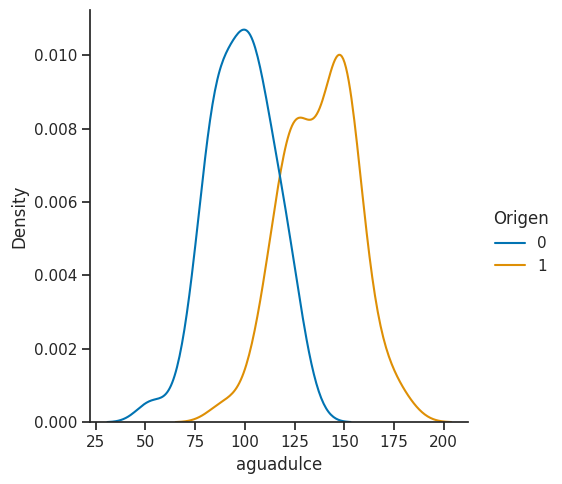

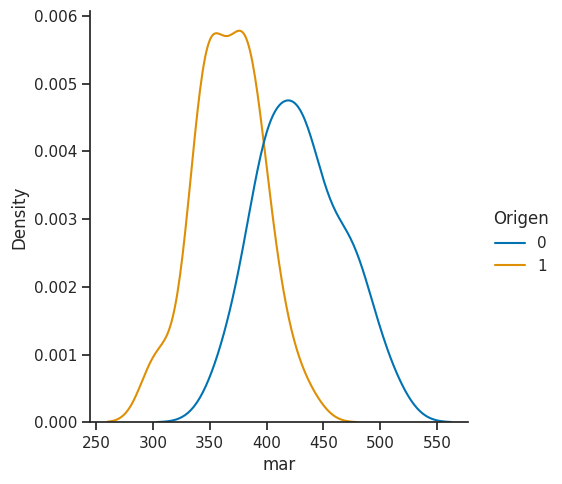

In [160]:
# EDA

data = dataSalmon

# Transformo Target en 0 y 1
# data['Origen'] = [0 if val == 'Alaska' else 1 for val in data.origen]
# data.drop(columns='origen', inplace=True)

# Exporto a R
%R -i data

# Grafico de Dispersion
# sns.scatterplot(data=data, x='aguadulce', y='mar', hue='Origen')
# plt.show()


# Distribucion de cada Variable Predictora
sns.displot(data=data, x='aguadulce', hue='Origen', kind='kde')
plt.show()

sns.displot(data=data, x='mar', hue='Origen', kind='kde')
plt.show()


Call:
glm(formula = Origen ~ aguadulce, family = "binomial", data = data)

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -16.33244    3.37525  -4.839 1.31e-06 ***
aguadulce     0.13932    0.02875   4.846 1.26e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 138.629  on 99  degrees of freedom
Residual deviance:  58.029  on 98  degrees of freedom
AIC: 62.029

Number of Fisher Scoring iterations: 6



                   2.5 %      97.5 %
(Intercept) -24.20323367 -10.7359637
aguadulce     0.09169013   0.2063183


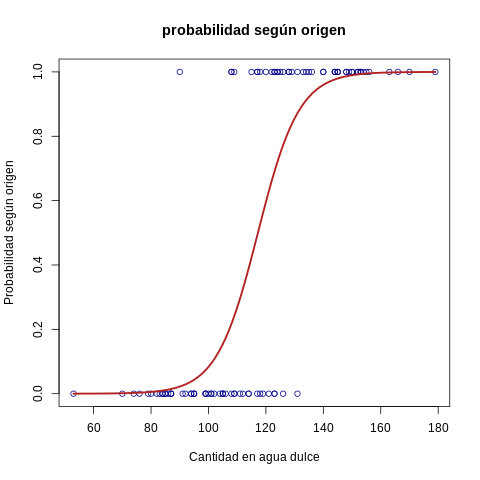

In [167]:
%%R

# Armamos el modelo
model_logi <- glm(Origen ~ aguadulce, data=data, family = 'binomial')
print(summary(model_logi))

# Ploteamos la Logistica
plot(x = data$aguadulce, y = data$Origen, col = "darkblue", main = "probabilidad según origen", xlab = "Cantidad en agua dulce", ylab = "Probabilidad según origen")
curve(predict(model_logi, data.frame(aguadulce=x), type = "response"), add = TRUE, col = "firebrick", lwd = 2.5)

# Aramamos el IC
print(confint(object=model_logi, level=0.95))

In [186]:
# Predecimos
%%R
library(ggplot2)

# Valores random
new_data <- seq(from = min(data$aguadulce), to = max(data$aguadulce), by = 0.5)

# Predecimos
predicciones <- predict(model_logi, data.frame(aguadulce=new_data), se.fit=TRUE)

# Transformamos en probabilidades
predicciones_logit <- exp(predicciones$fit)/(1+exp(predicciones$fit))

# Limites del IC al 95%
limite_inferior <- predicciones$fit - 1.96 * predicciones$se.fit
limite_inferior_logit <- exp(limite_inferior)/(1 + exp(limite_inferior))
limite_superior <- predicciones$fit + 1.96 * predicciones$se.fit
limite_superior_logit <- exp(limite_superior)/(1 + exp(limite_superior))

# Ploteamos
datos_curva <- data.frame(aguadulce = new_data, probabilidad_aguadulce = predicciones_logit, limite_inferior_logit = limite_inferior_logit, limite_superior_logit = limite_superior_logit)
plot1 <- ggplot(data, aes(x = aguadulce, y = Origen)) +
  geom_point(aes(color = as.factor(Origen)),shape = "I", size = 3) +
  geom_line(data = datos_curva, aes(y = probabilidad_aguadulce), color = "firebrick") +
  geom_line(data = datos_curva, aes(y = limite_inferior_logit), linetype = "dashed") +
  geom_line(data = datos_curva, aes(y = limite_superior_logit), linetype = "dashed") +
  theme_bw() +
  labs(title = "Modelo regresión logística Origen ~ aguadulce", y = "P(Origen = Canadá | aguadulce)", y = "Origen") +
  theme(legend.position = "null") + theme(plot.title = element_text(hjust = 0.5))
# plot(plot1)

# Deviance (diferencia de Residuos) -> p-value < .05 El modelo es Significativo
print(anova(model_logi, test='Chisq'))

Analysis of Deviance Table

Model: binomial, link: logit

Response: Origen

Terms added sequentially (first to last)


          Df Deviance Resid. Df Resid. Dev  Pr(>Chi)    
NULL                         99    138.629              
aguadulce  1   80.601        98     58.029 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [194]:
# Agregamos mas variables al modelo
%%R

# library(lmtest)

model_logi2 <- glm(Origen ~ aguadulce + mar, data=data, family='binomial')
# print(summary(model_logi2))

# Pruebas de verosimilitud -> H0: Modelos similares, H1: Modelo mejor
print(lrtest(model_logi, model_logi2))

Likelihood ratio test

Model 1: Origen ~ aguadulce
Model 2: Origen ~ aguadulce + mar
  #Df  LogLik Df Chisq Pr(>Chisq)    
1   2 -29.014                        
2   3 -19.394  1 19.24  1.153e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [195]:
# H0 -> Las Proporciones Observadas de eventos son similares a las
# Proporciones Predichas en cada subgrupo (El modelo se ajusta a los datos)
%%R

library(ResourceSelection)
HL <- hoslem.test(data$Origen, model_logi2$fitted.value)
print(HL)
print(cbind(HL$observed, HL$expected))


	Hosmer and Lemeshow goodness of fit (GOF) test

data:  data$Origen, model_logi2$fitted.value
X-squared = 4.9027, df = 8, p-value = 0.7679

                    y0 y1      yhat0       yhat1
[3.39e-05,0.000821] 10  0 9.99697033 0.003029675
(0.000821,0.00372]  10  0 9.98147052 0.018529481
(0.00372,0.0169]    10  0 9.90515506 0.094844940
(0.0169,0.126]       9  1 9.55949612 0.440503879
(0.126,0.587]        8  2 6.51347587 3.486524129
(0.587,0.816]        2  8 2.58917712 7.410822876
(0.816,0.949]        0 10 1.02011049 8.979889514
(0.949,0.981]        1  9 0.30610262 9.693897377
(0.981,0.997]        0 10 0.11392759 9.886072409
(0.997,1]            0 10 0.01411428 9.985885721
